# The effect of belief interaction on group polarization in networked experiments

Preregistration of analysis code

Todo:
- [ ] confidence intervals for game-level measures
- [ ] third hazard regression with fixed effects for each game and game*treatment
- [ ] correlation plot / regression calc btw. game-level imitation difference + pl2 difference and outcome measure difference
- [ ] fixed effect for game-startup time


In [376]:
%pylab inline
%load_ext rpy2.ipython

# for managing data
import pandas as pd
import networkx as nx
import json
from collections import Counter
import itertools
import copy
from datetime import datetime
import scipy.stats as stats

#from lifelines import CoxTimeVaryingFitter
from sklearn.decomposition import PCA


import string

Populating the interactive namespace from numpy and matplotlib
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['select', 'datetime', 'f', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Load data from experiment database

In [68]:
export_dir = "/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Experiment/empirica/detective-game/design/results/Empirica Data - 2020-01-16 17-53-52/"
players = []
with open(export_dir + 'players.json', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.json', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.json', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

logs = []
with open(export_dir + 'player-logs.json', 'r') as f:
    for line in f:
        entry = json.loads(line)
        entry['data'] = json.loads(entry['jsonData'])
        logs.append(entry)

# match games, players, treatments, and log info
loaded_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    game['log'] = [l for l in logs if l['gameId'] == game['_id']]
    
    loaded_games.append(game)
    
for i, game in enumerate(loaded_games):
    print(i, game['createdAt'])

0 2019-11-27T18:20:38.972Z
1 2019-12-11T17:08:10.631Z
2 2019-12-11T18:21:08.701Z
3 2019-12-18T15:21:44.815Z
4 2019-12-18T15:58:20.952Z
5 2020-01-16T17:36:13.359Z


In [71]:
# select which games to process
# Game 1 was a test game, for practice

select = [0, 2, 5]
process_games = [loaded_games[i] for i in select]

In [72]:
### this block includes one of the previous games that used a different format for log

export_dir = "/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Experiment/empirica/detective-game/design/results/Empirica Data - 2019-10-01 18-28-44/"
players = []
with open(export_dir + 'players.json', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.json', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.json', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

experiment_filepath = "/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Experiment/empirica/detective-game/design/results/exp_design4_matched_20190925_121500.json"
with open(experiment_filepath, 'r') as f:
    experiment = json.load(f)
    

# match games, players, experiment data
experiment_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    
    if game['gameSetupId'] in experiment['games'].keys():
        game['gameData'] = experiment['games'][game['gameSetupId']]
        game['data.clues'] = experiment['games'][game['gameSetupId']]['clues']
        experiment_games.append(game)
        print('%s loaded' %game['gameSetupId'])
    else:
        print('%s not in experiment' % game['gameSetupId'])
        
process_games.append(experiment_games[-1])


panel_1_matched_pair_exp_design3_matched_20190723_115409 not in experiment
panel_0_matched_pair_exp_design3_matched_20190723_115409 not in experiment
panel_0_matched_pair_exp_design3_matched_20190723_115409 not in experiment
panel_0_matched_pair_exp_design3_matched_20190726_115504 not in experiment
panel_0_matched_pair_exp_design4_matched_20190925_121500 loaded
panel_0_matched_pair_exp_design4_matched_20190925_121500 loaded


### Calculate Continuous-Time Measures

In [4]:
def retrace(game):
    """
    Uses the game log and starting conditions to recreate the state of the
    game at every change event.
    
    Returns a generator yielding (player_id, g, event) at each event in the game,

    *player_id* is the player logging the event,
    *g* is the state of the game following the event,
    *t* timestamp in seconds since game start

    Does not return an action if the only change is a list reordering.
    """
    #game_data = game['gameData']
    clues = game['data.clues']
    
    # create trace social network
    edge_list = []
    for player_id, player_data in game['players'].items():
        for alter_id in player_data['data.alterIDs']:
            edge_list.append([player_id, alter_id])
    g = nx.from_edgelist(edge_list)

    # give trace players starting information
    nx.set_node_attributes(
        g,
        name='pos',  # position in the social network
        values={a: game['players'][a]['data.position'] for a in g}
    )

    nx.set_node_attributes(
        g,
        name='M',  # M for mind/memory
        values={a: nx.from_edgelist([
            clues[bf]['nodes'] for bf in
            #game['players'][a]['data.intialState']['promising_leads']['clueIDs']
            game['players'][a]['data.initialState']['promising_leads']['clueIDs']
        ]) for a in g}
    )

    nx.set_node_attributes(
        g,
        name='F',  # F for forgetory
        values={i: nx.Graph() for i in g}
    )

    # yield the initial state of the experiment
    yield (None, g, 0)


    # trace game
    t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

    for event in game['log']:
        if event['name'] != 'drop': # only consider drop events
            continue
            
        player_id = event["playerId"]
        source = event['data']['source']
        dest = event['data']['dest']
        if 'clue' in event['data']:
            if event['data']['clue'] != None:
                edge = clues[event['data']['clue']]['nodes']
            else: # catch incomplete record
                print('Missing clueID for player %s from source %s at time %s' % (player_id, source, event['at']))
        else:
            print('player %s is missing a clue' % player_id)
            continue
        M = g.node[player_id]['M']
        F = g.node[player_id]['F']
        update = False

        if source == "promising_leads":
            assert g.node[player_id]['M'].has_edge(*edge) # check that clue is still in memory
            if dest == "dead_ends":
                M.remove_edge(*edge)
                F.add_edge(*edge)
                update = True

        elif source == "dead_ends":
            assert g.node[player_id]['F'].has_edge(*edge) # check that clue is still in forgettory
            if dest == "promising_leads":
                F.remove_edge(*edge)
                M.add_edge(*edge)
                update = True

        else:
            assert source in game['playerIds']  # check that source is another player
            if not g.node[source]['M'].has_edge(*edge):  # check that clue is in source
                # this can fail if the exposer removes the clue while the exposed is dragging it.
                # turns out not to be a big deal
                print("%s no longer in source %s" % (str(edge), str(source)))
            if dest == "promising_leads":
                M.add_edge(*edge)
                if F.has_edge(*edge):
                    F.remove_edge(*edge)
                update = True
            elif dest == "dead_ends":
                F.add_edge(*edge)
                if M.has_edge(*edge):
                    M.remove_edge(*edge)
                update = True
            assert not (F.has_edge(*edge) and  # not in both memory and forgetery
                        M.has_edge(*edge))

        if update:
            t_current = datetime.strptime(event['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            t = (t_current - t_start).total_seconds()
            yield (player_id, g, t)

    # double check the final state at the end of the generator
    for player_id in g:
        leads = game['players'][player_id]['data.notebooks']['promising_leads']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in leads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.node[player_id]['M'].edges()])
        assert should_have == has

        deads = game['players'][player_id]['data.notebooks']['dead_ends']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in deads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.node[player_id]['F'].edges()])
        assert should_have == has
       

In [35]:
def compute_adoption_hazard_table(game):
    
    def instantaneous_hazard_factors(game, g, t):
        """
        Given the state of the game, what are the factors that lead to adoption?

        Returns a row for the hazard factors of all individuals adopting all beliefs 
        at the time of the event, so this gets big fast

        """

        rows = []
        players = game['players']
        hub_elements = {game['data.nodes']['CrimeScene_1'], game['data.nodes']['StolenObject_1']}
        clue_ids = list(game['data.clues'])
        spoke_clue_ids = t_spokes+c_spokes  # defined in the outside scope
        spoke_edges = [game['data.clues'][clue_id]['nodes'] for clue_id in spoke_clue_ids]

        for player_id in players:
            position = players[player_id]['data.position']
            neighbors = g.neighbors(player_id)
            M = copy.deepcopy(g.node[player_id]['M'])  # promising leads (memory)
            F = copy.deepcopy(g.node[player_id]['F'])  # dead ends (forgetory)

            neighbor_clues = {nb: [] for nb in neighbors}
            exposers = {clue_id: [] for clue_id in clue_ids}
            player_leads = []
            player_deads = []
            for clue_id in clue_ids:
                if clue_id[0] != position[0]: # only collect treatment clues for treatment players, vice versa
                    continue 
                edge = game['data.clues'][clue_id]['nodes']
                if M.has_edge(*edge):
                    player_leads.append(clue_id)
                if F.has_edge(*edge):
                    player_deads.append(clue_id)

                for nb in g.neighbors(player_id):
                    if g.node[nb]['M'].has_edge(*edge):
                        neighbor_clues[nb].append(clue_id)
                        exposers[clue_id].append(nb)

            fresh_candidates = set([cl for cl, exps in exposers.items() if len(exps) > 0]) - set(player_leads) - set(player_deads)    
            n_fresh_candidates = len(fresh_candidates)

            n_existing_beliefs = len(player_leads)


            # Removing the central clue means that we're only going to count logical interactions
            # that go via one of the other spoke clues. Under control conditions there should never 
            # be a logical interaction. I do this after counting the number of existing beliefs.
            if M.has_edge(*tuple(hub_elements)):
                M = copy.deepcopy(M)
                M.remove_edge(*tuple(hub_elements)) # ignore the clue linking the crime scene to stolen object


            for clue_id in spoke_clue_ids:
                if clue_id[0] != position[0]: # only collect treatment clues for treatment players, vice versa
                    continue 

                edge = game['data.clues'][clue_id]['nodes']
                rim_node = (set(edge) - hub_elements).pop()

                row = {'game_player_clue_id': "%s_%s_%s" % (game['createdAt'], position, clue_id),
                       'game_player_id': "%s_%s" % (game['createdAt'], position),
                       'game_id': "%s"% game['createdAt'],
                       'start': t,
                       'treatment': position.startswith('t'),
                       'have_belief': clue_id in player_leads,
                       'in_deads': 1.0*(clue_id in player_deads),  # cast as float for regression
                       'n_exposures': len(exposers[clue_id]),
                       'n_existing_beliefs':n_existing_beliefs,
                       'n_fresh_candidates': n_fresh_candidates,
                       'player_clues': player_leads,
                      }

                # number of times the rim element is referenced in the existing belief set
                if set(edge) == hub_elements:
                    row['references'] = np.nan
                else:
                    row['references'] = len(M.edges(rim_node))


                # count of paths player has connecting ends of clue
                path_list = nx.all_simple_paths(M, *edge, cutoff=2) if set(edge)<set(M.nodes()) else []
                path_counts = pd.Series(pd.Series([len(pth) - 1 for pth in path_list]).value_counts(),
                                        index=range(1, 5)).fillna(0)
                row['pl2'] = path_counts[2]

                row['exposers_clues'] = {nb: cls for nb, cls in neighbor_clues.items() if nb in exposers[clue_id]}

                rows.append(row)

        return rows
    
    def drop_consecutive_duplicates(df, cols, sort_on):
        df = df.sort_values('start')
        return df.loc[any(df.shift(-1)[cols] != df[cols], axis=1).shift(+1).fillna('True').astype(bool)]

    def add_stops(df, t_last):
        df['stop'] = df['start'].shift(-1)
        df.loc[df.index[-1], 'stop'] = t_last
        return df

    def similarity_func(player_clues, alter_clues):
        # fraction of alter's total clues that player holds
        return len(set(player_clues) & set(alter_clues)) / len(alter_clues)


    def process_adoption_group(group):
        """
        Takes the hazard table and creates a table that lifelines can use.
        1. Condenses multiple rows (by dropping duplicates)
        2. Treats start and end times
        3. Identifies adoption events
        """

        return_cols=[
            'treatment', 'game_player_clue_id', 'game_player_id', 'game_id'
            'start', 'stop', 'adopt_event', 'forget_event',
            'n_exposures', 'n_fresh_candidates', 'have_belief',
            'pl2', 'references', 'n_existing_beliefs', 'in_deads',
            'max_similarity_to_exposer'
        ]

        #indexes at which exposures increase
        i_exposures = group.index[group['n_exposures'] > group.shift(+1)['n_exposures'].fillna(0)].tolist()
        if len(i_exposures) == 0:  # never exposed, throw out
            return pd.DataFrame()

        t_first_exposure = group[group['n_exposures']>0]['start'].min()
        if t_first_exposure < 15:  # exposed too early, throw out
             return pd.DataFrame()
        group['t_first_exposure'] = t_first_exposure

        # identify the exposer's clues at the time they expose you to the belief
        exposer_exposure_beliefs = {} # beliefs exposer held at the time of exposure
        for i in i_exposures:
            exposers_clues = group.loc[i]['exposers_clues']  # extract from array
            for exposer, clues in exposers_clues.items():
                if exposer not in exposer_exposure_beliefs: # new exposure
                    exposer_exposure_beliefs[exposer] = clues

        # use the list of current exposers to figure out the max similarity to any exposer at the time of exposure
        max_similarity_to_exposer = []
        for i, row in group.iterrows():
            if len(row['exposers_clues']) == 0:
                max_similarity_to_exposer.append(-1000)  # this should be nan, but the drop duplicates can't handle that
            else:
                similarities = [similarity_func(row['player_clues'], exposer_exposure_beliefs[exposer])
                                for exposer in row['exposers_clues']]
                max_similarity_to_exposer.append(np.max(similarities))
        group['max_similarity_to_exposer'] = max_similarity_to_exposer

        # 'stops' for current (short period) rows
        t_final = datetime.strptime(game['finishedAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
        t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
        total_time = (t_final-t_start).total_seconds()
        group = add_stops(group, total_time) 

        fgroup = group[
            (group['stop'] < 450) & # throw out periods after the right censor
            (group['start'] > 15) # throw out before left censor
        ] 

        if len(fgroup) == 0: # kick out empty groups before we bother with the rest
            return pd.DataFrame() 


        fgroup = drop_consecutive_duplicates(
            df=fgroup, 
            cols=['n_exposures', 'max_similarity_to_exposer', 'have_belief', 
                  'references', 'pl2', 'n_existing_beliefs', 'in_deads', 
                  'n_fresh_candidates'], 
            sort_on='start'
        )
        fgroup = add_stops(fgroup, total_time) # update stops for longer periods

        fgroup['adopt_event'] = fgroup['have_belief'] < fgroup.shift(-1)['have_belief']
        fgroup.loc[fgroup.index[-1], 'adopt_event'] = False

        fgroup['forget_event'] = fgroup['have_belief'] > fgroup.shift(-1)['have_belief']
        fgroup.loc[fgroup.index[-1], 'forget_event'] = False

        return fgroup[return_cols]


    hazard_factors_list = []
    for (player_id, g, t) in retrace(game):
        hazard_factors_list += instantaneous_hazard_factors(game, g, t)
    unprocessed_hazard_table = pd.DataFrame(hazard_factors_list)
    unprocessed_hazard_table.sort_values(['game_player_clue_id', 'start'], inplace=True)
    
    res_list = []
    for i, group in unprocessed_hazard_table.groupby('game_player_clue_id'):
        res_list.append(process_adoption_group(group))
    hazard_table = pd.concat(res_list)
    
    # interact each measure with the treatment dummy to get a regressor on the 
    # difference between treatment and control

    hazard_table['treatment_n_exposures'] = hazard_table['treatment']*hazard_table['n_exposures']
    hazard_table['treatment_references'] = hazard_table['treatment']*hazard_table['references']
    hazard_table['treatment_pl2'] = hazard_table['treatment']*hazard_table['pl2']
    hazard_table['treatment_n_existing_beliefs'] = hazard_table['treatment']*hazard_table['n_existing_beliefs']
    hazard_table['treatment_n_fresh_candidates'] = hazard_table['treatment']*hazard_table['n_fresh_candidates']
    hazard_table['treatment_max_similarity_to_exposer'] = hazard_table['treatment']*hazard_table['max_similarity_to_exposer']
    hazard_table['treatment_in_deads'] = hazard_table['treatment']*hazard_table['in_deads']*1.0

    # only look at potential adoptions
    adoption_hazard_table = hazard_table[(hazard_table['have_belief']==0) & (hazard_table['n_exposures'] > 0)]
    adoption_hazard_table['adopt_event'] *=1 # force to float
    adoption_hazard_table.reset_index(drop=True, inplace=True)

    return adoption_hazard_table
    
aht_collector = [compute_adoption_hazard_table(game) for game in process_games]
aht = pd.concat(aht_collector)
    
    
#aht['game_id'] = aht['game_player_id'].apply(lambda x: x.split('_')[0])
dummies = pd.get_dummies(aht['game_id'], prefix='game')
for col in dummies.columns:
    dummies['treatment_'+col] = dummies[col]*aht['treatment']
aht = pd.concat([aht, dummies], axis=1)


datafilename = "adoption_hazard_table.csv"
aht.to_csv(datafilename)
    

['a blue bucket hat', 'talking on a cellphone'] no longer in source HA94938qDZJzQz85w
['the bracelet', 'a blue Toyota Yaris'] no longer in source 2nc97cP2kWazJtbA9


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [401]:
aht['game_id'] = aht['game_player_id'].apply(lambda x: x.split('_')[0])
dummies = pd.get_dummies(aht['game_id'], prefix='game')
for col in dummies.columns:
    dummies['treatment_'+col] = dummies[col]*aht['treatment']
aht = pd.concat([aht, dummies], axis=1)

datafilename = "adoption_hazard_table.csv"
aht.to_csv(datafilename)

In [427]:
aht.drop(aht.columns[-7:], axis=1, inplace=True)

In [428]:
aht['game_id'] = aht['game_player_id'].apply(lambda x: x.split('_')[0].replace('-','_').replace(':','_').replace('.','_'))

dummies = pd.get_dummies(aht['game_id'], prefix='mse')
for col in dummies.columns:
    dummies[col] = dummies[col]*aht['max_similarity_to_exposer']
    dummies['treatment_'+col] = dummies[col]*aht['treatment']*aht['max_similarity_to_exposer']
aht = pd.concat([aht, dummies], axis=1)
dummy_cols = dummies.columns
datafilename = "adoption_hazard_table.csv"
aht.to_csv(datafilename)
aht

,treatment,game_player_clue_id,game_player_id,start,stop,adopt_event,forget_event,n_exposures,n_fresh_candidates,have_belief,...,treatment_pl2,treatment_n_existing_beliefs,treatment_n_fresh_candidates,treatment_max_similarity_to_exposer,treatment_in_deads,game_id,mse_2019_12_11T18_21_08_701Z,mse_2020_01_16T17_36_13_359Z,treatment_mse_2019_12_11T18_21_08_701Z,treatment_mse_2020_01_16T17_36_13_359Z
0,False,2019-12-11T18:21:08.701Z_c0_cclue_1_3,2019-12-11T18:21:08.701Z_c0,165.540,166.662,0,False,1,8,False,...,0.0,0,0,0.000000,0.0,2019_12_11T18_21_08_701Z,0.7,0.000000,0.0,0.000000
1,False,2019-12-11T18:21:08.701Z_c0_cclue_1_3,2019-12-11T18:21:08.701Z_c0,166.662,166.664,0,False,1,7,False,...,0.0,0,0,0.000000,0.0,2019_12_11T18_21_08_701Z,0.8,0.000000,0.0,0.000000
2,False,2019-12-11T18:21:08.701Z_c0_cclue_1_3,2019-12-11T18:21:08.701Z_c0,166.664,167.258,0,False,1,8,False,...,0.0,0,0,0.000000,0.0,2019_12_11T18_21_08_701Z,0.7,0.000000,0.0,0.000000
3,False,2019-12-11T18:21:08.701Z_c0_cclue_1_3,2019-12-11T18:21:08.701Z_c0,167.258,174.593,0,False,1,7,False,...,0.0,0,0,0.000000,0.0,2019_12_11T18_21_08_701Z,0.8,0.000000,0.0,0.000000
4,False,2019-12-11T18:21:08.701Z_c0_cclue_1_3,2019-12-11T18:21:08.701Z_c0,174.593,175.826,0,False,1,6,False,...,0.0,0,0,0.000000,0.0,2019_12_11T18_21_08_701Z,0.8,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6856,True,2020-01-16T17:36:13.359Z_t9_tclue_2_8,2020-01-16T17:36:13.359Z_t9,398.730,413.867,0,False,1,21,False,...,0.0,13,21,0.200000,0.0,2020_01_16T17_36_13_359Z,0.0,0.200000,0.0,0.040000
6857,True,2020-01-16T17:36:13.359Z_t9_tclue_2_8,2020-01-16T17:36:13.359Z_t9,413.867,490.802,0,False,1,20,False,...,0.0,13,20,0.200000,0.0,2020_01_16T17_36_13_359Z,0.0,0.200000,0.0,0.040000
6858,True,2020-01-16T17:36:13.359Z_t9_tclue_2_9,2020-01-16T17:36:13.359Z_t9,317.344,322.362,0,False,1,26,False,...,1.0,10,26,0.192308,0.0,2020_01_16T17_36_13_359Z,0.0,0.192308,0.0,0.036982
6859,True,2020-01-16T17:36:13.359Z_t9_tclue_2_9,2020-01-16T17:36:13.359Z_t9,322.362,354.525,0,False,1,25,False,...,1.0,11,25,0.230769,0.0,2020_01_16T17_36_13_359Z,0.0,0.230769,0.0,0.053254


In [434]:
any ((aht['mse_2019_12_11T18_21_08_701Z'] > 0) &
     (aht['mse_2020_01_16T17_36_13_359Z'] > 0) &
     (aht['treatment_mse_2019_12_11T18_21_08_701Z'] > 0) &
     (aht['treatment_mse_2020_01_16T17_36_13_359Z'] > 0))
     


False

In [36]:
!say "hazard rate factors calculation complete"

In [40]:
aht.iloc[0]

treatment                                                              False
game_player_clue_id                    2019-12-11T18:21:08.701Z_c0_cclue_1_3
game_player_id                                   2019-12-11T18:21:08.701Z_c0
start                                                                 165.54
stop                                                                 166.662
adopt_event                                                                0
forget_event                                                           False
n_exposures                                                                1
n_fresh_candidates                                                         8
have_belief                                                            False
pl2                                                                        0
references                                                                 0
n_existing_beliefs                                                         8

# First cox regression

In [282]:
%%R -i datafilename -o r1_summary -o r1_fit
# Running R in a python notebook: https://stackoverflow.com/a/41889995/6361632
# In this cell, use the R package 'survival'
# perform a cox regression on the whole experiment
# https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/coxph
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/frailty

# This regression calculates parameters for all experiments together, and is 
# not used for the mediation analysis pieces


library(survival)
df <- read.csv(file=datafilename, header=TRUE, stringsAsFactors=FALSE)


r1_fit <- coxph(Surv(time=start, time2=stop, event=adopt_event, type='counting') ~ 
      n_exposures + references + n_existing_beliefs + n_fresh_candidates + in_deads + 
      treatment_n_exposures + treatment_pl2 + treatment_references + treatment_n_existing_beliefs +
      treatment_n_fresh_candidates + treatment_in_deads +
      frailty.gaussian(game_player_id),
      data=df)

print(r1_fit)

r1_summary = summary(r1_fit)
print(r1_summary)

Call:
coxph(formula = Surv(time = start, time2 = stop, event = adopt_event, 
    type = "counting") ~ n_exposures + references + n_existing_beliefs + 
    n_fresh_candidates + in_deads + treatment_n_exposures + treatment_pl2 + 
    treatment_references + treatment_n_existing_beliefs + treatment_n_fresh_candidates + 
    treatment_in_deads + frailty.gaussian(game_player_id), data = df)

                               coef  se(coef)       se2     Chisq   DF       p
n_exposures                 0.39727   0.15630   0.15216   6.46003  1.0   0.011
references                  0.38637   0.07247   0.07046  28.42535  1.0 9.7e-08
n_existing_beliefs          0.00457   0.02485   0.02154   0.03386  1.0   0.854
n_fresh_candidates         -0.12751   0.01936   0.01685  43.39938  1.0 4.5e-11
in_deads                   -2.01057   0.31025   0.30364  41.99756  1.0 9.1e-11
treatment_n_exposures       0.19846   0.22861   0.22030   0.75360  1.0   0.385
treatment_pl2               0.28279   0.13884   0.13509   

In [301]:
r1_summary_dict = dict(zip(r1_summary.names, r1_summary))
r1 = pd.concat(
    [pd.DataFrame(data=np.array(r1_summary_dict['coefficients']), columns=['coef', 'se(coef)', 'se2', 'Chisq', 'DF', 'p']),
     pd.DataFrame(data=np.array(r1_summary_dict['conf.int']), columns=['exp(coef)', 'exp(-coef)', 'lower .95', 'upper .95'])],
    axis=1)
r1.index = r1_fit[15].names
r1

,coef,se(coef),se2,Chisq,DF,p,exp(coef),exp(-coef),lower .95,upper .95
n_exposures,0.397273,0.156305,0.152160,6.460026,1.000000,1.103280e-02,1.487762,0.672151,1.095183,2.021064
references,0.386371,0.072469,0.070459,28.425349,1.000000,9.738186e-08,1.471631,0.679518,1.276771,1.696229
n_existing_beliefs,0.004572,0.024847,0.021538,0.033857,1.000000,8.540123e-01,1.004582,0.995438,0.956831,1.054716
n_fresh_candidates,-0.127513,0.019356,0.016847,43.399384,1.000000,4.463287e-11,0.880282,1.136000,0.847512,0.914318
in_deads,-2.010566,0.310246,0.303643,41.997557,1.000000,9.138754e-11,0.133913,7.467541,0.072902,0.245983
treatment_n_exposures,0.198461,0.228614,0.220295,0.753601,1.000000,3.853384e-01,1.219524,0.819992,0.779100,1.908918
treatment_pl2,0.282786,0.138844,0.135087,4.148196,1.000000,4.167892e-02,1.326821,0.753681,1.010713,1.741794
treatment_references,-0.106371,0.107961,0.105186,0.970766,1.000000,3.244893e-01,0.899091,1.112234,0.727625,1.110964
treatment_n_existing_beliefs,-0.054783,0.022146,0.019878,6.119294,1.000000,1.337142e-02,0.946691,1.056311,0.906478,0.988687
treatment_n_fresh_candidates,0.026936,0.019756,0.017386,1.858940,1.000000,1.727472e-01,1.027302,0.973424,0.988284,1.067861


### Assess M0 manipulation check

In [298]:
if (all(aht['pl2'] == aht['treatment_pl2']) and  # pl2 is 0 for all control cases, so valid to exclude non-interacted pl2 from regression
    r1.loc['treatment_pl2']['coef'] > 0 and  # positive effect of belief interactions
    r1.loc['treatment_pl2']['p'] < .05):  # significant
    print("The manipulation check is satisfied")
else:
    print("The manipulation check is not satisfied")

The manipulation check is satisfied


### Assess H1

In [299]:
if (r1.loc['references']['coef'] > 0 and
    r1.loc['references']['p'] < .05):
    print("H1a is satisfied")
else:
    print("H1a is not satisfied")
    
if (r1.loc['treatment_references']['coef'] < 0 and
    r1.loc['treatment_references']['p'] < .05):
    print("H1b is satisfied")
else:
    print("H1b is not satisfied")

H1a is satisfied
H1b is not satisfied


# second cox regression

In [300]:
%%R -i datafilename -o r2_summary -o r2_fit
# Running R in a python notebook: https://stackoverflow.com/a/41889995/6361632
# In this cell, use the R package 'survival'
# perform a cox regression on the whole experiment
# https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/coxph
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/frailty

# This regression calculates parameters for all experiments together, and is 
# not used for the mediation analysis pieces


library(survival)
df <- read.csv(file=datafilename, header=TRUE, stringsAsFactors=FALSE)


r2_fit <- coxph(Surv(time=start, time2=stop, event=adopt_event, type='counting') ~ 
      n_exposures + max_similarity_to_exposer + n_existing_beliefs + n_fresh_candidates + in_deads + 
      treatment_n_exposures + treatment_max_similarity_to_exposer + treatment_n_existing_beliefs +
      treatment_n_fresh_candidates + treatment_in_deads +
      frailty.gaussian(game_player_id),
      data=df)

print(r2_fit)

r2_summary = summary(r2_fit)
print(r2_summary)

Call:
coxph(formula = Surv(time = start, time2 = stop, event = adopt_event, 
    type = "counting") ~ n_exposures + max_similarity_to_exposer + 
    n_existing_beliefs + n_fresh_candidates + in_deads + treatment_n_exposures + 
    treatment_max_similarity_to_exposer + treatment_n_existing_beliefs + 
    treatment_n_fresh_candidates + treatment_in_deads + frailty.gaussian(game_player_id), 
    data = df)

                              coef se(coef)      se2    Chisq   DF       p
n_exposures                 0.4959   0.1555   0.1518  10.1676  1.0  0.0014
max_similarity_to_exposer   0.7156   0.3873   0.3688   3.4136  1.0  0.0647
n_existing_beliefs          0.0135   0.0269   0.0237   0.2519  1.0  0.6157
n_fresh_candidates         -0.1121   0.0197   0.0173  32.3211  1.0 1.3e-08
in_deads                   -2.0730   0.3098   0.3039  44.7665  1.0 2.2e-11
treatment_n_exposures       0.0852   0.2397   0.2336   0.1263  1.0  0.7223
treatment_max_similarity_   0.4857   0.5921   0.5669   0.6728  1.0 

In [302]:
r2_summary_dict = dict(zip(r2_summary.names, r2_summary))
r2 = pd.concat(
    [pd.DataFrame(data=np.array(r2_summary_dict['coefficients']), columns=['coef', 'se(coef)', 'se2', 'Chisq', 'DF', 'p']),
     pd.DataFrame(data=np.array(r2_summary_dict['conf.int']), columns=['exp(coef)', 'exp(-coef)', 'lower .95', 'upper .95'])],
    axis=1)
r2.index = r2_fit[15].names
r2

,coef,se(coef),se2,Chisq,DF,p,exp(coef),exp(-coef),lower .95,upper .95
n_exposures,0.495864,0.155508,0.151848,10.167612,1.000000,1.429293e-03,1.641916,0.609045,1.210549,2.226997
max_similarity_to_exposer,0.715583,0.387306,0.368828,3.413597,1.000000,6.466137e-02,2.045379,0.488907,0.957411,4.369673
n_existing_beliefs,0.013505,0.026906,0.023703,0.251927,1.000000,6.157212e-01,1.013596,0.986586,0.961529,1.068483
n_fresh_candidates,-0.112078,0.019714,0.017288,32.321055,1.000000,1.306896e-08,0.893975,1.118600,0.860091,0.929193
in_deads,-2.073034,0.309835,0.303865,44.766457,1.000000,2.219933e-11,0.125804,7.948900,0.068543,0.230900
treatment_n_exposures,0.085185,0.239729,0.233586,0.126265,1.000000,7.223369e-01,1.088918,0.918343,0.680671,1.742020
treatment_max_similarity_to_exposer,0.485652,0.592071,0.566853,0.672827,1.000000,4.120678e-01,1.625234,0.615296,0.509266,5.186655
treatment_n_existing_beliefs,-0.024969,0.026905,0.025159,0.861247,1.000000,3.533900e-01,0.975340,1.025283,0.925240,1.028153
treatment_n_fresh_candidates,0.019006,0.020015,0.017707,0.901784,1.000000,3.423037e-01,1.019188,0.981173,0.979981,1.059964
treatment_in_deads,0.125251,0.498502,0.490284,0.063129,1.000000,8.016172e-01,1.133433,0.882276,0.426649,3.011073


### Assess H2

In [305]:
if (r2.loc['max_similarity_to_exposer']['coef'] > 0 and
    r2.loc['max_similarity_to_exposer']['p'] < .05):
    print("H2a is satisfied")
else:
    print("H2a is not satisfied")
    
if (r2.loc['treatment_max_similarity_to_exposer']['coef'] > 0 and
    r2.loc['treatment_max_similarity_to_exposer']['p'] < .05):
    print("H2b is satisfied")
else:
    print("H2b is not satisfied")

H2a is not satisfied
H2b is not satisfied


# Compute game-level measures

In [96]:
def compute_single_point_measures(game):
    """ Compute the game-level measures """
    # Form end-of-game survey responses into a dataframe
    collector = {}
    for p, k in game['players'].items():
        try:
            collector[k['data.position']] = k['data.caseMade']
        except:
            print('%s did not complete the post-game survey' %k['data.position'])
    responses = pd.DataFrame(collector).T.sort_index()

    # Define clues used in polarization analysis
    # final clues used in analysis are connections between hub nodes (1,2) and rim nodes (3-13)
    t_spokes = ['tclue_1_3', 'tclue_1_4', 'tclue_1_5', 'tclue_1_6', 'tclue_1_7', 
                'tclue_1_8', 'tclue_1_9', 'tclue_1_10','tclue_1_11', 'tclue_1_12', 'tclue_1_13',
                'tclue_2_3', 'tclue_2_4', 'tclue_2_5', 'tclue_2_6', 'tclue_2_7',
                'tclue_2_8', 'tclue_2_9', 'tclue_2_10', 'tclue_2_11', 'tclue_2_12', 'tclue_2_13']

    c_spokes = ['cclue_1_3', 'cclue_1_4', 'cclue_1_5', 'cclue_1_6', 'cclue_1_7', 
                'cclue_1_8', 'cclue_1_9', 'cclue_1_10','cclue_1_11', 'cclue_1_12', 'cclue_1_13',
                'cclue_2_3', 'cclue_2_4', 'cclue_2_5', 'cclue_2_6', 'cclue_2_7',
                'cclue_2_8', 'cclue_2_9', 'cclue_2_10', 'cclue_2_11', 'cclue_2_12', 'cclue_2_13']

    # Form initial notebook states into a dataframe
    initial_adoptions = pd.DataFrame(data=0, index=responses.index, columns=t_spokes+c_spokes)
    for p, k in game['players'].items():
        for clue_id in k['data.initialState']['promising_leads']['clueIDs']:
            initial_adoptions.loc[k['data.position'], clue_id] = 1

    # Form final notebook states into a dataframe
    final_adoptions = pd.DataFrame(data=0, index=responses.index, columns=t_spokes+c_spokes)
    for p, k in game['players'].items():
        for clue_id in k['data.notebooks']['promising_leads']['clueIDs']:
            final_adoptions.loc[k['data.position'], clue_id] = 1

    # Define end-of-game survey questions to be used in polarization analysis
    assessments = ['appearance_1', 'appearance_2', 
                   'clothing_1', 'clothing_2',
                   'suspect_1', 'suspect_2', 'suspect_3',
                   'tool_1', 'tool_2', 
                   'vehicle_1', 'vehicle_2']

    # Determine the number of datapoints to be used in polarization analysis
    # if there are missing responses, need to compare equal sized datasets
    t_responses = [pos for pos in responses.index if pos.startswith('t')]
    c_responses = [pos for pos in responses.index if pos.startswith('c')] 
    # use whichever condition has fewer responses to set the sample size
    n_used = min(len(t_responses), len(c_responses))


    def process_subset(subset, spokes, prefix='_t'):
        """ compute a result on the selected subset of the data """
        sub_res = {}
        # survey PC1 
        pca = PCA(n_components=1)
        pca.fit(responses.loc[subset, assessments])  
        sub_res[prefix+'survey_pc1_variance'] = pca.explained_variance_ratio_

        # survey similarity percentiles
        sub_res[prefix+'survey_5th_similarity'], sub_res[prefix+'survey_95th_similarity'] = np.percentile(
            responses.loc[subset, assessments].T.corr().mask(
                np.tri(n_used, n_used, 0, dtype='bool')).stack(), [5, 95])
        
        # initial-state PC1
        pca = PCA(n_components=1)
        pca.fit(initial_adoptions.loc[subset, spokes])  
        sub_res[prefix+'spoke_pc1_initial_variance'] = pca.explained_variance_ratio_

        # final-state PC1
        pca = PCA(n_components=1)
        pca.fit(final_adoptions.loc[subset, spokes])  
        sub_res[prefix+'spoke_pc1_variance'] = pca.explained_variance_ratio_
        
        # pc1 growth
        sub_res[prefix+'spoke_pc1_growth'] = sub_res[prefix+'spoke_pc1_variance'] - sub_res[prefix+'spoke_pc1_initial_variance']

        # final state similarity percentiles
        sub_res[prefix+'spoke_5th_similarity'], sub_res[prefix+'spoke_95th_similarity'] = np.percentile(
            final_adoptions.loc[subset, spokes].T.corr().mask(
                np.tri(n_used, n_used, 0, dtype='bool')).stack(), [5, 95])
        
        return sub_res
        
        
    # For each subset of size 'n_used', compute a result. 
    # In most cases there are no missing responses, so just compute on the complete set
    t_collector = []
    for subset in itertools.combinations(t_responses, r=n_used):
        t_collector.append(process_subset(subset, t_spokes, prefix='t_'))

    # The recorded result is the average over all subsets
    if len(t_collector) > 1:
        print('Averaging over %i combinations for treatment case'%len(t_collector))
    t_result = pd.DataFrame(t_collector).mean()

    # Compute average for confidence and consensus measures on all submissions
    t_result['t_confidence'] = responses.loc[t_responses, 'confidence'].mean()
    t_result['t_consensus'] = responses.loc[t_responses, 'consensus'].mean()    

    
    # Perform the same analysis as above for the control condition
    c_collector = []
    for subset in itertools.combinations(c_responses, r=n_used):
        c_collector.append(process_subset(subset, c_spokes, prefix='c_'))

    if len(c_collector) > 1:
        print('Averaging over %i combinations for control case'%len(c_collector))
    c_result = pd.DataFrame(c_collector).mean()

    c_result['c_confidence'] = responses.loc[c_responses, 'confidence'].mean()
    c_result['c_consensus'] = responses.loc[c_responses, 'consensus'].mean()      

    
    
    result = pd.concat([t_result, c_result])
    result['game_id']=game['createdAt']
    return result

spms = pd.DataFrame([compute_single_point_measures(game) for game in process_games])
spms.set_index('game_id', inplace=True)
spms.T

t10 did not complete the post-game survey
Averaging over 20 combinations for control case


game_id,2019-11-27T18:20:38.972Z,2019-12-11T18:21:08.701Z,2020-01-16T17:36:13.359Z,2019-10-01T18:05:24.798Z
t_survey_pc1_variance,0.328309,0.436489,0.305909,0.306978
t_survey_5th_similarity,-0.465841,-0.486749,-0.395919,-0.501332
t_survey_95th_similarity,0.659589,0.815220,0.647553,0.608929
t_spoke_pc1_initial_variance,0.143541,0.139744,0.095694,0.193572
t_spoke_pc1_variance,0.263857,0.313525,0.377400,0.334609
t_spoke_pc1_growth,0.120317,0.173781,0.281706,0.141037
t_spoke_5th_similarity,-0.274634,-0.195694,-0.264060,-0.252708
t_spoke_95th_similarity,0.628958,0.623932,0.744363,0.694444
t_confidence,51.500000,51.650000,48.250000,50.263158
t_consensus,52.150000,54.100000,53.850000,49.263158


In [309]:
# todo: add 95% confidence intervals

collector = []
for key in spms:
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        collector.append({
            'Measure': key.lstrip('t_'), #.replace('_', ' ').title(),
            'Treatment Mean': spms[key].mean(),
            'Control Mean': spms[control_key].mean(),
            'Mean Difference': (spms[key] - spms[control_key]).mean(),
            'Percent Difference of Means': (spms[key] - spms[control_key]).mean() / spms[control_key].mean()*100,
            'p value': stats.ttest_rel(spms[key], spms[control_key])[1]
        })
r3 = pd.DataFrame(collector).set_index('Measure')
r3

,Treatment Mean,Control Mean,Mean Difference,Percent Difference of Means,p value
Measure,,,,,
survey_pc1_variance,0.344422,0.278341,0.066081,23.740906,0.110802
survey_5th_similarity,-0.462460,-0.368200,-0.094260,25.600297,0.038797
survey_95th_similarity,0.682823,0.710766,-0.027943,-3.931459,0.562572
spoke_pc1_initial_variance,0.143138,0.142122,0.001015,0.714374,0.391002
spoke_pc1_variance,0.322348,0.272851,0.049497,18.140603,0.179194
spoke_pc1_growth,0.179210,0.130729,0.048482,37.085637,0.187558
spoke_5th_similarity,-0.246774,-0.198101,-0.048673,24.569924,0.251114
spoke_95th_similarity,0.672924,0.668078,0.004846,0.725389,0.933651
confidence,50.415789,49.925000,0.490789,0.983054,0.852160


# third cox regression

In [437]:
%%R -i datafilename -i dummy_cols -o r4_summary -o r4_fit
# Running R in a python notebook: https://stackoverflow.com/a/41889995/6361632
# In this cell, use the R package 'survival'
# perform a cox regression on the whole experiment
# https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/coxph
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/frailty

# This regression calculates parameters for all experiments together, and is 
# not used for the mediation analysis pieces

fmla <- as.formula(paste("Surv(time=start, time2=stop, event=adopt_event, type='counting') ~ 
      n_exposures + n_existing_beliefs + n_fresh_candidates + in_deads + 
      treatment_n_exposures + treatment_n_existing_beliefs +
      treatment_n_fresh_candidates + treatment_in_deads +
      frailty.gaussian(game_player_id) + ", paste(dummy_cols, collapse= "+")))

print(fmla)

library(survival)
df <- read.csv(file=datafilename, header=TRUE, stringsAsFactors=FALSE)


r4_fit <- coxph(fmla,
      data=df)

print(r4_fit)

r4_summary = summary(r4_fit)
print(r4_summary)

Surv(time = start, time2 = stop, event = adopt_event, type = "counting") ~ 
    n_exposures + n_existing_beliefs + n_fresh_candidates + in_deads + 
        treatment_n_exposures + treatment_n_existing_beliefs + 
        treatment_n_fresh_candidates + treatment_in_deads + frailty.gaussian(game_player_id) + 
        mse_2019_12_11T18_21_08_701Z + mse_2020_01_16T17_36_13_359Z + 
        treatment_mse_2019_12_11T18_21_08_701Z + treatment_mse_2020_01_16T17_36_13_359Z
Call:
coxph(formula = fmla, data = df)

                               coef  se(coef)       se2     Chisq   DF       p
n_exposures                 0.54041   0.15448   0.15069  12.23784  1.0 0.00047
n_existing_beliefs          0.02232   0.02649   0.02323   0.71009  1.0 0.39941
n_fresh_candidates         -0.11553   0.01998   0.01760  33.43529  1.0 7.4e-09
in_deads                   -2.10716   0.31016   0.30431  46.15423  1.0 1.1e-11
treatment_n_exposures       0.00824   0.23564   0.22883   0.00122  1.0 0.97209
treatment_n_existin

### Assess H3

In [314]:
if (r3.loc['spoke_95th_similarity']['Mean Difference'] > 0 and
   r3.loc['spoke_95th_similarity']['p value'] < .05):
    print('H3a is satisfied')
else:
    print('H3a is not satisfied')
    

if (r3.loc['survey_95th_similarity']['Mean Difference'] > 0 and
   r3.loc['survey_95th_similarity']['p value'] < .05):
    print('H3b is satisfied')
else:
    print('H3b is not satisfied')

H3a is not satisfied
H3b is not satisfied


### Assess H4

In [315]:
if (r3.loc['spoke_5th_similarity']['Mean Difference'] < 0 and
   r3.loc['spoke_5th_similarity']['p value'] < .05):
    print('H4a is satisfied')
else:
    print('H4a is not satisfied')
    

if (r3.loc['survey_5th_similarity']['Mean Difference'] < 0 and
   r3.loc['survey_5th_similarity']['p value'] < .05):
    print('H4b is satisfied')
else:
    print('H4b is not satisfied')

H4a is not satisfied
H4b is satisfied


### Assess H5

In [320]:
if (r3.loc['confidence']['Mean Difference'] > 0 and
   r3.loc['confidence']['p value'] < .05):
    print('H6a is satisfied')
else:
    print('H6a is not satisfied')
    

if (r3.loc['consensus']['Mean Difference'] > 0 and
   r3.loc['consensus']['p value'] < .05):
    print('H6b is satisfied')
else:
    print('H6b is not satisfied')

H6a is not satisfied
H6b is not satisfied


### Assess H6

In [ ]:
if (r3.loc['spoke_pc1_growth']['Mean Difference'] > 0 and
   r3.loc['spoke_pc1_growth']['p value'] < .05):
    print('H5a is satisfied')
else:
    print('H5a is not satisfied')
    

if (r3.loc['survey_pc1_variance']['Mean Difference'] > 0 and
   r3.loc['survey_pc1_variance']['p value'] < .05):
    print('H5b is satisfied')
else:
    print('H5b is not satisfied')

# Plots

In [323]:
plt.rcParams.update({
    "figure.dpi": 100,
    "figure.facecolor": "white", #"lightyellow",
    
    "savefig.dpi": 150,
    
    "font.family": "san-serif",
    "font.sans-serif": "Helvetica",

    
    "text.color": "grey",
    "text.usetex": False
})

([<matplotlib.axis.YTick at 0x1a42837410>,
 <a list of 6 Text yticklabel objects>)

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


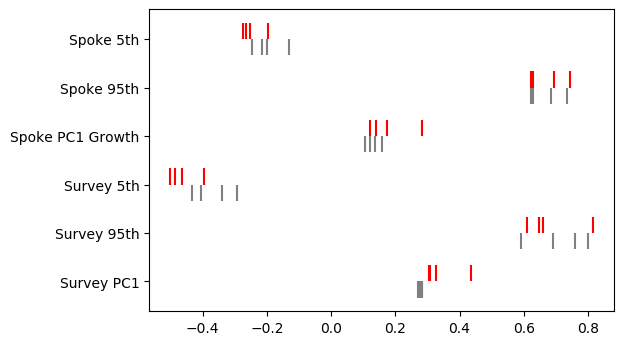

In [324]:
plt.vlines(spms['c_survey_pc1_variance'], ymin=0, ymax=1, color='grey')
plt.vlines(spms['t_survey_pc1_variance'], ymin=1, ymax=2, color='r')

plt.vlines(spms['c_survey_95th_similarity'], ymin=3, ymax=4, color='grey')
plt.vlines(spms['t_survey_95th_similarity'], ymin=4, ymax=5, color='r')

plt.vlines(spms['c_survey_5th_similarity'], ymin=6, ymax=7, color='grey')
plt.vlines(spms['t_survey_5th_similarity'], ymin=7, ymax=8, color='r')

plt.vlines(spms['c_spoke_pc1_growth'], ymin=9, ymax=10, color='grey')
plt.vlines(spms['t_spoke_pc1_growth'], ymin=10, ymax=11, color='r')

plt.vlines(spms['c_spoke_95th_similarity'], ymin=12, ymax=13, color='grey')
plt.vlines(spms['t_spoke_95th_similarity'], ymin=13, ymax=14, color='r')

plt.vlines(spms['c_spoke_5th_similarity'], ymin=15, ymax=16, color='grey')
plt.vlines(spms['t_spoke_5th_similarity'], ymin=16, ymax=17, color='r')



plt.yticks([1, 4, 7, 10, 13, 16], ['Survey PC1', 'Survey 95th', 'Survey 5th', 'Spoke PC1 Growth', 'Spoke 95th', 'Spoke 5th'])

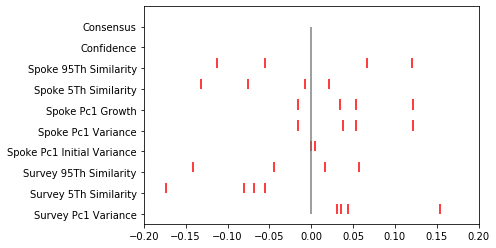

In [98]:
labels = []
ys = []
for i, key in enumerate(spms):
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        y = 2*i
        ys.append(y)
        plt.vlines(spms[key] - spms[control_key], ymin=y, ymax=y+1, color='r')
        labels.append(key.lstrip('t_').replace('_', ' ').title())
plt.yticks(ys, labels)
plt.xlim(-.2,.2)
plt.vlines(0, 0, max(ys), color='grey')
#plt.axis('off')

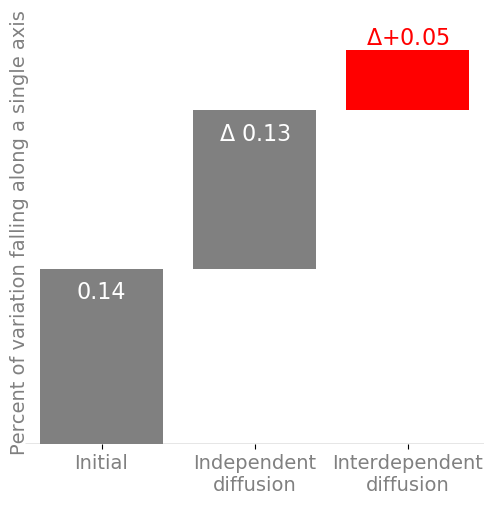

In [327]:
plt.figure(figsize=(5,5))

start = r3.loc['spoke_pc1_initial_variance']['Treatment Mean']
control = r3.loc['spoke_pc1_variance']['Control Mean']
treatment = r3.loc['spoke_pc1_variance']['Treatment Mean']

plt.bar(x=[0,1,2], 
        height=[start,
                control-start, 
                treatment-control],
        bottom=[0, 
                start,
                control], 
        color=['grey', 'grey', 'r'])


plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.box(on=False)

plt.xlim(-.5, 2.5)
plt.xticks([0,1,2], ['Initial', 'Independent\ndiffusion', 'Interdependent\ndiffusion'], 
           ha='center', fontsize=14, color='grey');
plt.yticks([])
plt.text(0, start-.01, '%.02f'%start, ha='center', va='top', color='white', fontsize=16)
plt.text(1, control-.01, '$\Delta$ %.02f'%(control-start), ha='center', va='top', color='white', fontsize=16)
plt.text(2, treatment, '$\Delta$+%.02f'%(treatment-control), ha='center', va='bottom', color='r', fontsize=16)

          
plt.figtext(x=0, y=1, rotation=90, va='top', fontsize=14, color='grey',
            s='Percent of variation falling along a single axis')
plt.tight_layout()

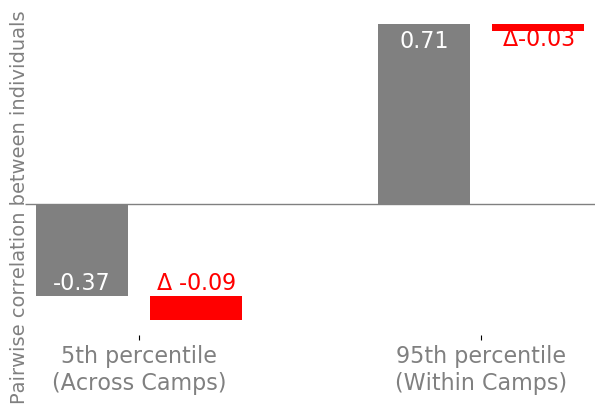

In [330]:

control_across = r3.loc['survey_5th_similarity']['Control Mean']
treatment_across = r3.loc['survey_5th_similarity']['Treatment Mean']
control_within = r3.loc['survey_95th_similarity']['Control Mean']
treatment_within = r3.loc['survey_95th_similarity']['Treatment Mean']

plt.bar(x=[0,1, 3,4], 
        height=[control_across, treatment_across-control_across, 
                control_within, treatment_within-control_within],
        bottom=[0, control_across, 0, control_within], 
        color=['grey', 'r', 'grey', 'r'])

plt.box(on=False)
plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.xlim(-.5, 4.5)
plt.xticks([0.5,3.5], ['5th percentile\n(Across Camps)', '95th percentile\n(Within Camps)'], ha='center', fontsize=16, color='grey');
plt.yticks([])

plt.text(0, control_across+.01, '%.02f'%control_across, 
         ha='center', va='bottom', color='white', fontsize=16)
plt.text(1, control_across+.01, '$\Delta$ %.02f'%(treatment_across-control_across), 
         ha='center', va='bottom', color='r', fontsize=16)
plt.text(3, control_within-.02, '%.02f'%control_within, 
         ha='center', va='top', color='white', fontsize=16)
plt.text(4, control_within-.01, '$\Delta$%.02f'%(treatment_within-control_within), 
         ha='center', va='top', color='r', fontsize=16)

plt.figtext(x=0, y=1, s='Pairwise correlation between individuals', 
            rotation=90, va='top', color='grey', fontsize=14)
plt.tight_layout()


,coef,se(coef),se2,Chisq,DF,p,exp(coef),exp(-coef),lower .95,upper .95
n_exposures,0.397273,0.156305,0.152160,6.460026,1.000000,1.103280e-02,1.487762,0.672151,1.095183,2.021064
references,0.386371,0.072469,0.070459,28.425349,1.000000,9.738186e-08,1.471631,0.679518,1.276771,1.696229
n_existing_beliefs,0.004572,0.024847,0.021538,0.033857,1.000000,8.540123e-01,1.004582,0.995438,0.956831,1.054716
n_fresh_candidates,-0.127513,0.019356,0.016847,43.399384,1.000000,4.463287e-11,0.880282,1.136000,0.847512,0.914318
in_deads,-2.010566,0.310246,0.303643,41.997557,1.000000,9.138754e-11,0.133913,7.467541,0.072902,0.245983
treatment_n_exposures,0.198461,0.228614,0.220295,0.753601,1.000000,3.853384e-01,1.219524,0.819992,0.779100,1.908918
treatment_pl2,0.282786,0.138844,0.135087,4.148196,1.000000,4.167892e-02,1.326821,0.753681,1.010713,1.741794
treatment_references,-0.106371,0.107961,0.105186,0.970766,1.000000,3.244893e-01,0.899091,1.112234,0.727625,1.110964
treatment_n_existing_beliefs,-0.054783,0.022146,0.019878,6.119294,1.000000,1.337142e-02,0.946691,1.056311,0.906478,0.988687
treatment_n_fresh_candidates,0.026936,0.019756,0.017386,1.858940,1.000000,1.727472e-01,1.027302,0.973424,0.988284,1.067861


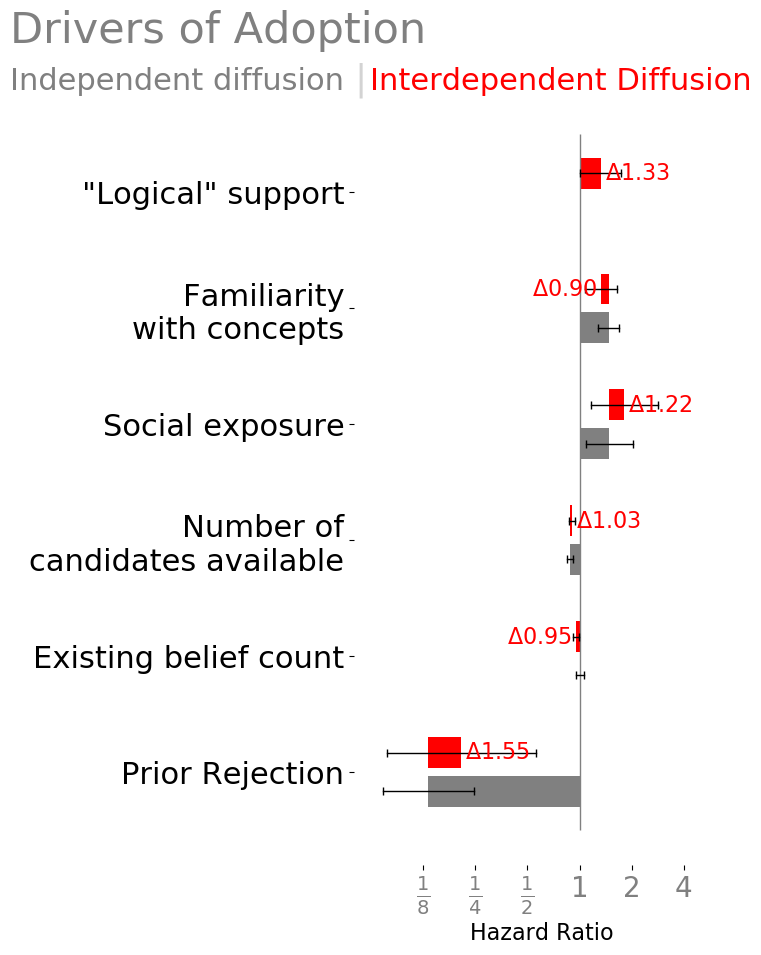

In [372]:
plt.figure(figsize=(8,10))
plt.rcParams["font.family"] = "san-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"


ctrl = ['in_deads', 'n_existing_beliefs', 'n_fresh_candidates', 'n_exposures', 'references']
trmt = ['treatment_in_deads', 'treatment_n_existing_beliefs', 'treatment_n_fresh_candidates', 
        'treatment_n_exposures', 'treatment_references', 'treatment_pl2']


ctrl_ys = np.arange(0, len(trmt)*3,3)
trmt_ys = ctrl_ys + 1

ctrl_width = list(r1['coef'].loc[ctrl])+[0]
trmt_diff =list(r1['coef'].loc[trmt])

ctrl_95 = log(r1[['lower .95', 'upper .95']].T[ctrl])
trmt_95 = log(r1[['lower .95', 'upper .95']].T[trmt])+ctrl_width

plt.barh(y=ctrl_ys, 
         width=ctrl_width,
         left=0, 
         color='grey')

plt.plot(ctrl_95, 
         [ctrl_ys[:-1], ctrl_ys[:-1]], 
         'k-|', linewidth=1, alpha=1)

plt.barh(y=trmt_ys, 
         width=trmt_diff,
         left=ctrl_width, 
         color='red')

plt.plot(trmt_95, 
         [trmt_ys, trmt_ys], 
         'k-|', linewidth=1, alpha=1)


plt.xlim(-3, 2)

labels = ['Prior Rejection', 'Existing belief count', 'Number of\ncandidates available',  
          'Social exposure', 'Familiarity\nwith concepts', '"Logical" support']
plt.yticks(np.arange(0.5, len(trmt)*3, 3), labels, fontsize=22)
plt.xticks(np.log([.125, .25,.5,1,2,4]), [r'$\frac{1}{8}$', r'$\frac{1}{4}$',r'$\frac{1}{2}$',1,2,4], 
           fontsize=20, color='grey')
plt.xlabel('Hazard Ratio', fontsize=16)

plt.vlines(0, -1, len(trmt)*3-1, linewidth=1, color='grey')
plt.box(False)


for td, cw, y in zip(trmt_diff, ctrl_width, trmt_ys):
    xp = td + cw + .05 * np.sign(td)
    plt.text(#xp, y, '$\Delta$%s%.02f'%('+' if td>=0 else '', exp(td)-1), 
             xp, y, '$\Delta$%.02f'%(exp(td)), 
             ha='left' if td>0 else 'right', 
             va='center', color='r', fontsize=16, alpha=1)



plt.suptitle('Drivers of Adoption', x=0, ha='left', fontsize=31)
plt.figtext(x=0, y=.9, s='Independent diffusion',  ha='left', fontsize=22)
plt.figtext(x=.43, y=.9, s='|',  ha='left', fontsize=26, color='lightgrey')
plt.figtext(x=.45, y=.9, s='Interdependent Diffusion',  ha='left', fontsize=22, color='r')


plt.subplots_adjust(top=.89, left=.43)
# plt.savefig('/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Thesis/drivers_of_adoption_logic_0.png', dpi=150)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.


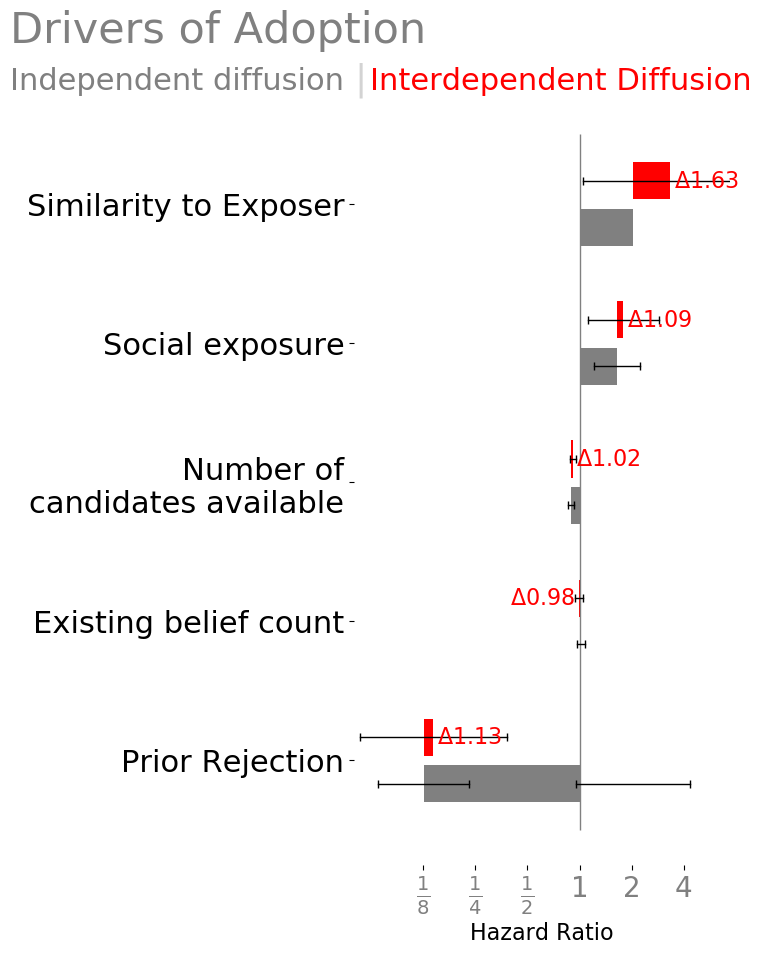

In [373]:
plt.figure(figsize=(8,10))
plt.rcParams["font.family"] = "san-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"


ctrl = ['in_deads', 'n_existing_beliefs', 'n_fresh_candidates', 'n_exposures', 'max_similarity_to_exposer']
trmt = ['treatment_in_deads', 'treatment_n_existing_beliefs', 'treatment_n_fresh_candidates', 
        'treatment_n_exposures', 'treatment_max_similarity_to_exposer']


ctrl_ys = np.arange(0, len(trmt)*3,3)
trmt_ys = ctrl_ys + 1

ctrl_width = list(r2['coef'].loc[ctrl])
trmt_diff =list(r2['coef'].loc[trmt])

ctrl_95 = log(r2[['lower .95', 'upper .95']].T[ctrl])
trmt_95 = log(r2[['lower .95', 'upper .95']].T[trmt])+ctrl_width

plt.barh(y=ctrl_ys, 
         width=ctrl_width,
         left=0, 
         color='grey')

plt.plot(ctrl_95, 
         [ctrl_ys[:-1], ctrl_ys[:-1]], 
         'k-|', linewidth=1, alpha=1)

plt.barh(y=trmt_ys, 
         width=trmt_diff,
         left=ctrl_width, 
         color='red')

plt.plot(trmt_95, 
         [trmt_ys, trmt_ys], 
         'k-|', linewidth=1, alpha=1)


plt.xlim(-3, 2)

labels = ['Prior Rejection', 'Existing belief count', 'Number of\ncandidates available',  
          'Social exposure', 'Similarity to Exposer']
plt.yticks(np.arange(0.5, len(trmt)*3, 3), labels, fontsize=22)
plt.xticks(np.log([.125, .25,.5,1,2,4]), [r'$\frac{1}{8}$', r'$\frac{1}{4}$',r'$\frac{1}{2}$',1,2,4], 
           fontsize=20, color='grey')
plt.xlabel('Hazard Ratio', fontsize=16)

plt.vlines(0, -1, len(trmt)*3-1, linewidth=1, color='grey')
plt.box(False)


for td, cw, y in zip(trmt_diff, ctrl_width, trmt_ys):
    xp = td + cw + .05 * np.sign(td)
    plt.text(#xp, y, '$\Delta$%s%.02f'%('+' if td>=0 else '', exp(td)-1), 
             xp, y, '$\Delta$%.02f'%(exp(td)), 
             ha='left' if td>0 else 'right', 
             va='center', color='r', fontsize=16, alpha=1)



plt.suptitle('Drivers of Adoption', x=0, ha='left', fontsize=31)
plt.figtext(x=0, y=.9, s='Independent diffusion',  ha='left', fontsize=22)
plt.figtext(x=.43, y=.9, s='|',  ha='left', fontsize=26, color='lightgrey')
plt.figtext(x=.45, y=.9, s='Interdependent Diffusion',  ha='left', fontsize=22, color='r')


plt.subplots_adjust(top=.89, left=.43)
# plt.savefig('/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Thesis/drivers_of_adoption_logic_0.png', dpi=150)


# open responses

In [381]:
def process_open_responses(process_games):
    
    fair = []
    length = []
    feedback = []
    
    for game in process_games:
        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'fair' in player['data.survey'].keys():
                    s = player['data.survey']['fair']
                    fair.append(s.lower().translate(str.maketrans('', '', string.punctuation)))

        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'time' in player['data.survey'].keys():
                    s = player['data.survey']['time']
                    length.append(s.lower().translate(str.maketrans('', '', string.punctuation)))

        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'feedback' in player['data.survey'].keys():
                    s = player['data.survey']['feedback']
                    feedback.append(s.lower().translate(str.maketrans('', '', string.punctuation)))

    return (pd.DataFrame(pd.Series(fair).value_counts()), 
            pd.DataFrame(pd.Series(length).value_counts()), 
            pd.DataFrame(pd.Series(feedback).value_counts()))

fair, length, feedback = process_open_responses(process_games)

In [382]:
fair

,0
yes,110
yes very fair,3
yes,3
no,2
very fair,2
yeah,2
yes paid to have fun,1
yes the pay is fair,1
its okay,1
totally,1


In [388]:
length

,0
yes,107
no,3
yes i did,3
yes,2
yeah,1
felt kinda rushed at the end but i managed to sort most of the clues,1
yes it was plenty,1
yes i di,1
i would have liked to of had more time,1
i had plenty of time to play,1


In [387]:
pd.options.display.max_rows = 999
feedback

,0
,28
none,26
no issues,4
fun survey,2
no problems,2
i did not encounter any problems,2
very good hit i enjoyed it a lot,1
i didnt encounter any problems even the wait time was short it was incredibly fun thank you,1
the final page of questions took forever to let me submit it,1
the names were just mentioned with no reason they were linked to the crime,1
